# Using DeepLab v3+ to classify road data

The implementation is at https://github.com/bonlime/keras-deeplab-v3-plus?1527772905297

In [1]:
from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
import numpy as np
from model import Deeplabv3
import math

/home/tom/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
deeplab_model = Deeplabv3()
#img = plt.imread("./data/Train/CameraRGB/326.png")
img = plt.imread("imgs/image1.jpg")
w, h, _ = img.shape
ratio = 512. / np.max([w,h])
resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))
resized = resized / 127.5 - 1.
pad_x = int(512 - resized.shape[0])
resized2 = np.pad(resized,((0,pad_x),(0,0),(0,0)),mode='constant')
res = deeplab_model.predict(np.expand_dims(resized2,0))
labels = np.argmax(res.squeeze(),-1)
plt.imshow(labels[:-pad_x])

In [2]:
from model import Deeplabv3
import keras
num_classes = 13

deeplab_model = Deeplabv3(input_shape=(256, 800,3), classes=13, backbone='xception')

In [ ]:
model_layers = deeplab_model.layers

for i in range(1, 410):
    print(str(i) + ": " + model_layers[i].name)

In [3]:
model_layers = deeplab_model.layers

#for i in range(1, 395):
#for i in range(1, 406):
for i in range(1, 356):
#for i in range(1, 145):
    model_layers[i].trainable = False
    
#last_weights = deeplab_model.get_layer("custom_logits_semantic").get_weights()
#print(last_weights)
    
#optimizer = keras.optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.9, clipnorm=0.1)
#optimizer = keras.optimizers.SGD(lr=.000001, decay=0.1, momentum=0.9, clipnorm=0.1)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=0.1)
deeplab_model.compile(loss='binary_crossentropy', optimizer=optimizer)
#deeplab_model.compile(loss=ncce, optimizer=optimizer)
#deeplab_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [4]:
import helper
import os.path

data_dir = '../data'
image_shape = (256, 800)
batch_size = 16

gen_batch_func = helper.gen_batch_function_c(os.path.join(data_dir, 'Train'), image_shape)
gen_batch_func_valid = helper.gen_batch_function_c(os.path.join(data_dir, 'Validate'), image_shape)

In [5]:
def show_image(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

def show_categorization(im, figsize=(8,8), ax=None, alpha=None, title=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='nipy_spectral', alpha=alpha)
    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)
    return ax

In [ ]:
gen_batch_func2 = helper.gen_batch_function_c(os.path.join(data_dir, 'Train'), image_shape)

for image, label in gen_batch_func2(1):
    show_image(image[0])
    show_categorization(np.argmax(label[0].squeeze(),-1))
    break

In [6]:
from keras.utils import plot_model
plot_model(deeplab_model, to_file='model.png')

deeplab_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 800, 3)  0                                            
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 128, 400, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 128, 400, 32) 128         entry_flow_conv1_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 400, 32) 0           entry_flow_conv1_1_BN[0][0]      
__________________________________________________________________________________________________
entry_flow

### Repeat until you think it is OK to stop, 10 epochs for each training

In [10]:
import keras.backend as K

class_weights = np.ones((600, 800, 13))
class_weights[:,:, 7] += 1
class_weights[:,:, 10] += 4

terminate_on_nan_callback = keras.callbacks.TerminateOnNaN()
print("Current learning rate %.3f" % K.get_value(deeplab_model.optimizer.lr))
deeplab_model.fit_generator(gen_batch_func(batch_size), 
                            math.ceil(6236/batch_size), 5, 
                            validation_data=gen_batch_func_valid(batch_size),
                            validation_steps=math.ceil(172/batch_size),
                            callbacks=[terminate_on_nan_callback])

Current learning rate 0.001
Epoch 1/5
390/390 [==============================] - 405s 1s/step - loss: 0.0295 - val_loss: 0.1085
Epoch 2/5
390/390 [==============================] - 392s 1s/step - loss: 0.0281 - val_loss: 0.1145
Epoch 3/5
390/390 [==============================] - 398s 1s/step - loss: 0.0270 - val_loss: 0.1996
Epoch 4/5
390/390 [==============================] - 393s 1s/step - loss: 0.0267 - val_loss: 0.2818
Epoch 5/5
390/390 [==============================] - 393s 1s/step - loss: 0.0260 - val_loss: 0.1202


debug (256, 800)


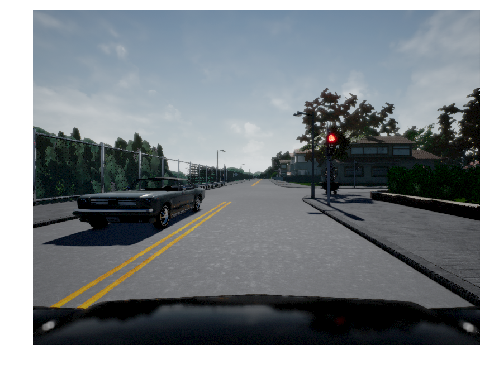

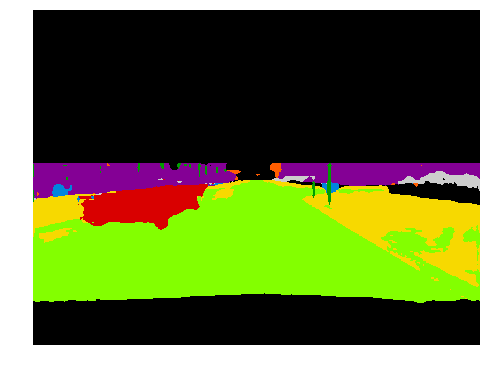

In [11]:
def crop_image(image):
    return image[274:530,:,:]

def pad_image(image):
    result = np.zeros((600,800))
    result[274:530,:] = image
    return result

img = plt.imread("../data/Test/CameraRGB/000109.png")

resized =crop_image(img)
res = deeplab_model.predict(np.expand_dims(resized,0))
labels = np.argmax(res.squeeze(),-1)
show_image(img)
print('debug', labels.shape)
show_categorization(pad_image(labels))

In [ ]:
def get_car_label(res):
    return np.logical_or(np.argsort(res.squeeze(),-1)[:,:,-1] == 10, np.argsort(res.squeeze(),-1)[:,:,-2] == 10)

def get_road_label(res):
    return np.argmax(res.squeeze(),-1) == 7

car_label = get_car_label(res)
road_label = get_road_label(res)

show_categorization(car_label)
show_categorization(road_label)

In [12]:
deeplab_model.save("deeplab_15_trim_xception_a.h5")

## Save the model to Tensorflow PB

code adopted from https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
from keras import backend as K
import tensorflow as tf

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in deeplab_model.outputs])

tf.train.write_graph(frozen_graph, "./", "deeplab_10e_carla.pb", as_text=False)

## Check input and output of the exported model

In [ ]:
import tensorflow as tf
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    model_filename ='deeplab_10e_carla.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
LOGDIR='./log/deeplab_10e_carla'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

## Load my model

In [ ]:
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def preprocess_labels(label_image):
    # Identify lane marking pixels (label is 6)
    labels_new = np.copy(label_image)
    lane_marking_pixels = (label_image[:,:,0] == 6).nonzero()
    # Set lane marking pixels to road (label is 7)
    labels_new[lane_marking_pixels] = 7

    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == 10).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    return labels_new


def show_image(im, figsize=(8,8), ax=None, alpha=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

def show_categorization(im, figsize=(8,8), ax=None, alpha=None, title=None):
    if not ax: fix, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='nipy_spectral', alpha=alpha)
    ax.set_axis_off()
    if title is not None:
        ax.set_title(title)
    return ax

In [ ]:
def crop_image(image):
    return image[274:530,:,:]

def pad_image(image):
    result = np.zeros((600,800))
    result[274:530,:,:] = image
    return result

In [ ]:
sample_image = scipy.misc.imread('../data/Test/CameraRGB/000109.png')
sample_label = scipy.misc.imread('../data/Test/CameraSeg/000109.png')
processed_label = preprocess_labels(sample_label)
result_min = scipy.misc.imread('./runs/1528045617.7575192/000109.png')
#result = scipy.misc.imresize(result_min, (600,800), interp='nearest')
#result_pad = pad_image(result_min)

f, ax = plt.subplots(1, 3, sharey=False, figsize=(14,5))
show_image(sample_image,ax=ax[0])
show_categorization(processed_label[:,:,0], ax=ax[1])
show_categorization(result_min[:,:,0], ax=ax[2])
plt.show()

In [ ]:
show_categorization(result[:,:,0]==10)

In [ ]:
## CV2 vs Scipy in resize

In [ ]:
import sys, skvideo.io, json, base64
from PIL import Image
from io import BytesIO
import tensorflow as tf
import sys
import numpy as np
import scipy
import os
import cv2
from matplotlib import pyplot as plt

sample_image = scipy.misc.imread('../data/Test/CameraRGB/000017.png')
image_shape= (384,512)

image_scipy = scipy.misc.imresize(sample_image, image_shape)
image_cv2 = cv2.resize(sample_image, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_CUBIC)

f, ax = plt.subplots(1, 2, sharey=False, figsize=(8, 4))
show_image(image_scipy,ax=ax[0])
show_image(image_cv2,ax=ax[1])

## Improve performance, add the argmax layer

In [ ]:
from keras.models import load_model
from model import BilinearUpsampling, SepConv_BN
from keras import backend as K

prev_model = load_model("./model/deeplab_10_full.h5", custom_objects={'BilinearUpsampling':BilinearUpsampling}) # loading the previously saved model.

In [ ]:
from keras import Model
from model import Argmax

output = prev_model.output
output = Argmax()(output)

aug_model = Model(inputs=prev_model.input, outputs=output)

In [ ]:
img = plt.imread("../data/Test/CameraRGB/000109.png")
w, h, _ = img.shape
ratio = 512. / np.max([w,h])
resized = cv2.resize(img,(800, 608))
res = aug_model.predict(np.expand_dims(resized,0))
#labels = np.argmax(res.squeeze(),-1)
print('debug', res.shape)
show_image(resized)
show_categorization(res[0])

In [ ]:
aug_model.summary()

aug_model.save("deeplab_10_full_argmax.h5")